In [20]:
import torch
import wandb, os, json
import time

from muon import Muon
from model_model import TransformerModel
from model_electrode_embedding import ElectrodeEmbedding_Learned, ElectrodeEmbedding_NoisyCoordinate, ElectrodeEmbedding_Learned_CoordinateInit, ElectrodeDataEmbeddingFFT, ElectrodeDataEmbedding

from dataset import load_dataloaders
from evaluation_btbench import FrozenModelEvaluation_SS_SM
from train_utils import log, update_dir_name, update_random_seed, convert_dtypes, parse_configs_from_args, get_default_configs, get_shared_memory_info

training_config, model_config, cluster_config = get_default_configs(random_string="TEMP", wandb_project="")
training_config.update({
    'train_subject_trials': [("btbank3", 0)],
    'eval_subject_trials': [("btbank3", 0)],
})

#parse_configs_from_args(training_config, model_config, cluster_config)
dir_name = update_dir_name(model_config, training_config, cluster_config)
update_random_seed(training_config)
cluster_config['wandb_name'] = cluster_config['dir_name']
log(f"Directory name: {dir_name}", priority=0)

if len(cluster_config['wandb_project'])==0: wandb = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log(f"Using device: {device}", priority=0)


log(f"Loading dataloaders...", priority=0)
n_samples = model_config['max_n_timebins'] * model_config['sample_timebin_size']
all_subjects, train_dataloader, test_dataloader = load_dataloaders(
    training_config['train_subject_trials'], training_config['eval_subject_trials'], training_config['p_test'], 
    model_config['sample_timebin_size'], model_config['max_n_timebins'], training_config['data_dtype'], 
    training_config['batch_size'],
    num_workers_dataloaders=cluster_config['num_workers_dataloaders'], 
    cache=cluster_config['cache_subjects'], allow_corrupted=False,
    prefetch_factor=cluster_config['prefetch_factor'],
)

eval_subject_trials = [(all_subjects[subject_identifier], trial_id) for subject_identifier, trial_id in training_config['eval_subject_trials']]
evaluation = FrozenModelEvaluation_SS_SM(
    ['speech', 'volume', 'gpt2_surprisal', 'word_part_speech'], eval_subject_trials, 
    training_config['data_dtype'], training_config['batch_size'] * 2, # Can have a bigger batch size here if that speeds things up
    num_workers_eval=cluster_config['num_workers_eval'],
    prefetch_factor=cluster_config['prefetch_factor'],
    feature_aggregation_method=cluster_config['eval_aggregation_method'],
)

[22:14:12 gpu 14.4G ram 7.6G] (0) Directory name: M_nst1_dm192_nh12_nl5_5_eaM_eeL_fb1_lr0.003_rTEMP
[22:14:12 gpu 14.4G ram 7.6G] (0) Using device: cuda
[22:14:12 gpu 14.4G ram 7.6G] (0) Loading dataloaders...
[22:14:12 gpu 14.4G ram 7.6G] (1)     loading subject btbank3...
[22:14:12 gpu 14.4G ram 7.6G] (1)     loading dataset for btbank3_0...
[22:14:51 gpu 14.4G ram 10.9G] (1)     finished loading dataset for btbank3_0


In [21]:

model = TransformerModel(
    model_config['transformer']['d_model'],  
    n_layers_electrode=model_config['transformer']['n_layers_electrode'], 
    n_layers_time=model_config['transformer']['n_layers_time'],
    n_heads=model_config['transformer']['n_heads'],
    use_cls_token=model_config['transformer']['use_cls_token']
).to(device, dtype=model_config['dtype'])

if model_config['electrode_embedding']['type'] == 'learned' or model_config['electrode_embedding']['type'] == 'zero':
    electrode_embeddings = ElectrodeEmbedding_Learned(
        model_config['transformer']['d_model'], 
        embedding_dim=model_config['electrode_embedding']['embedding_dim'],
        embedding_requires_grad=model_config['electrode_embedding']['type'] != 'zero'
    )
elif model_config['electrode_embedding']['type'] == 'coordinate_init':
    electrode_embeddings = ElectrodeEmbedding_Learned_CoordinateInit(
        model_config['transformer']['d_model'], 
        embedding_dim=model_config['electrode_embedding']['embedding_dim']
    )
elif model_config['electrode_embedding']['type'] == 'noisy_coordinate':
    electrode_embeddings = ElectrodeEmbedding_NoisyCoordinate(
        model_config['transformer']['d_model'], 
        coordinate_noise_std=model_config['electrode_embedding']['coordinate_noise_std'],
        embedding_dim=model_config['electrode_embedding']['embedding_dim']
    )
else:
    raise ValueError(f"Invalid electrode embedding type: {model_config['electrode_embedding']['type']}")
electrode_embeddings = electrode_embeddings.to(device, dtype=model_config['dtype'])

if model_config['electrode_embedding']['spectrogram']:
    electrode_data_embeddings = ElectrodeDataEmbeddingFFT(
        electrode_embeddings, model_config['sample_timebin_size'], 
        max_frequency=model_config['max_frequency']
    ).to(device, dtype=model_config['dtype'])
else:
    electrode_data_embeddings = ElectrodeDataEmbedding(
        electrode_embeddings, model_config['sample_timebin_size'], 
        overall_sampling_rate=next(iter(all_subjects.values())).get_sampling_rate(0) # XXX remove this once figured out how to be flexible here regarding the sampling rate
    ).to(device, dtype=model_config['dtype'])

for subject in all_subjects.values():
    this_subject_trials = [trial_id for (sub_id, trial_id) in training_config['train_subject_trials'] if sub_id == subject.subject_identifier]
    electrode_data_embeddings.add_subject(subject, subject.get_sampling_rate(this_subject_trials[0]))
    log(f"Adding subject {subject.subject_identifier} to electrode data embeddings...", priority=0)
    if model_config['init_normalization']:
        for trial_id in this_subject_trials:
            log(f"Initializing normalization for subject {subject.subject_identifier} trial {trial_id}...", priority=1, indent=1)
            electrode_data_embeddings.initialize_normalization(subject, trial_id, init_normalization_window_to=int(subject.get_sampling_rate(trial_id) * 60 * 5))
electrode_data_embeddings = electrode_data_embeddings.to(device, dtype=model_config['dtype']) # moving to device again to ensure the new parameters are on the correct device



all_params = list(model.parameters()) + list(electrode_data_embeddings.parameters())
n_model_params = sum(p.numel() for p in model.parameters())
n_embed_params = sum(p.numel() for p in electrode_data_embeddings.parameters())
log(f"Model parameters: {n_model_params:,}", priority=0)
log(f"Embedding parameters: {n_embed_params:,}", priority=0)
log(f"Total parameters: {n_model_params + n_embed_params:,}", priority=0)
model_config['n_params'] = {
    'model': n_model_params,
    'embeddings': n_embed_params,
    'total': n_model_params + n_embed_params
}

optimizers = []
if training_config['optimizer'] == 'Muon':
    matrix_params = [p for p in all_params if p.ndim >= 2]
    other_params = [p for p in all_params if p.ndim < 2]

    optimizers.append(Muon(matrix_params, lr=training_config['learning_rate'], momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5, weight_decay=training_config['weight_decay']))
    optimizers.append(torch.optim.AdamW(other_params, lr=training_config['learning_rate'], weight_decay=training_config['weight_decay']))
else:
    optimizers = [torch.optim.AdamW(all_params, lr=training_config['learning_rate'], weight_decay=training_config['weight_decay'])]


[22:15:05 gpu 14.4G ram 10.9G] (0) Adding subject btbank3 to electrode data embeddings...
[22:15:05 gpu 14.4G ram 10.9G] (1)     Initializing normalization for subject btbank3 trial 0...
[22:15:05 gpu 14.4G ram 10.9G] (0) Model parameters: 4,571,329
[22:15:05 gpu 14.4G ram 10.9G] (0) Embedding parameters: 52,161
[22:15:05 gpu 14.4G ram 10.9G] (0) Total parameters: 4,623,490


In [22]:
proj_type = None#'random_batch_nR' # None, 'random_batch', 'Norm'
dir_name = update_dir_name(model_config, training_config, cluster_config) + f'_proj_{proj_type}'

def calculate_loss_function(batch, subject_identifier, trial_id):
    electrode_embedded_data = electrode_data_embeddings.forward(subject_identifier, all_subjects[subject_identifier].get_electrode_indices(trial_id), 
                                                             batch, max_n_electrodes=model_config['max_n_electrodes'])
    
    batch_size, n_electrodes, n_timebins, d_model = electrode_embedded_data.shape

    permutation = torch.randperm(n_electrodes)
    electrode_embedded_data = electrode_embedded_data[:, permutation]

    n_electrodes_per_stream = int(n_electrodes * training_config['p_electrodes_per_stream'])
    o1_e, o1_t = model(electrode_embedded_data[:, :n_electrodes_per_stream, :, :]) # shape: (batch_size, n_timebins, d_model)
    o2_e, o2_t = model(electrode_embedded_data[:, -n_electrodes_per_stream:, :, :]) # shape: (batch_size, n_timebins, d_model)

    if proj_type == 'random_batch':
        random_matrix = torch.randn(d_model, d_model, device=model.device, dtype=torch.float32)
        q, r = torch.linalg.qr(random_matrix)  # Get orthogonal matrix via QR decomposition
        random_matrix = q.to(model.device, dtype=model_config['dtype'])  # q is an orthogonal matrix
    elif proj_type == 'random_batch_nR':
        random_matrix = torch.randn(d_model, d_model, device=model.device, dtype=model_config['dtype']) / (d_model ** 0.5)
    else:
        random_matrix = torch.eye(d_model, device=model.device, dtype=model_config['dtype'])
    o1_t = torch.matmul(o1_t, random_matrix)
    o2_t = torch.matmul(o2_t, random_matrix)
    o1_e = torch.matmul(o1_e, random_matrix)
    o2_e = torch.matmul(o2_e, random_matrix)
    
    similarity_1 = torch.matmul(o1_t[:, :-training_config['future_bin_idx']].permute(1, 0, 2), o2_e[:, training_config['future_bin_idx']:].permute(1, 2, 0)) * model.temperature_param
    expanded_arange = torch.arange(batch_size).unsqueeze(0).repeat(n_timebins-training_config['future_bin_idx'], 1).to(model.device, dtype=torch.long).reshape(-1)
    loss = torch.nn.functional.cross_entropy(similarity_1.view(-1, batch_size), expanded_arange)

    if training_config['symmetric_loss']:
        similarity_2 = torch.matmul(o2_t[:, :-training_config['future_bin_idx']].permute(1, 0, 2), o1_e[:, training_config['future_bin_idx']:].permute(1, 2, 0)) * model.temperature_param
        loss += torch.nn.functional.cross_entropy(similarity_2.view(-1, batch_size), expanded_arange)
        loss /= 2
    
    return {'contrastive': loss}


In [23]:
training_statistics_store = []
if wandb: 
    wandb.init(project=cluster_config['wandb_project'], name=cluster_config['wandb_name'], id=cluster_config['wandb_name'],
    config={"training_config": training_config, "model_config": model_config, "cluster_config": cluster_config}, settings=wandb.Settings(init_timeout=480))
for epoch_i in range(training_config['n_epochs']):
    epoch_start_time = time.time()
    model.train()

    # Main training loop
    epoch_losses = {}
    for batch_idx, (batch, (subject_identifiers, trial_ids)) in enumerate(train_dataloader):
        for optimizer in optimizers: optimizer.zero_grad()
        subject_identifier = subject_identifiers[0]
        trial_id = trial_ids[0].item()
        
        batch = batch.to(device, dtype=model_config['dtype'], non_blocking=True)
        loss_dict = calculate_loss_function(batch, subject_identifier, trial_id)

        for key, loss in loss_dict.items():
            if key not in epoch_losses: epoch_losses[key] = 0
            epoch_losses[key] += loss.item()

        loss = sum(loss_dict.values()) / len(loss_dict)
        loss.backward()
        for optimizer in optimizers: optimizer.step()

        training_statistics_store.append({
            'epoch': epoch_i+1,
            'batch': batch_idx+1,
            'subject_identifier': subject_identifier,
            'trial_id': trial_id,
            'batch_loss': loss.item(),
            'timestamp': time.time(),
            **{f"batch_{k}": v.item() for k, v in loss_dict.items()}
        })

        log(f"Epoch {epoch_i+1}/{training_config['n_epochs']}, Batch {batch_idx+1}/{len(train_dataloader)} ({subject_identifier}_{trial_id}), Loss: {loss.item():.4f}", priority=0)
    for key, loss in epoch_losses.items():
        epoch_losses[key] /= len(train_dataloader)

    # Evaluate the model
    model.eval()
    eval_results = {f"train_{k}": v for k, v in epoch_losses.items()}
    eval_results['train_loss'] = sum(epoch_losses.values()) / len(epoch_losses)
    with torch.no_grad():
        test_loss_dict = model.calculate_pretrain_test_loss(electrode_data_embeddings, test_dataloader, all_subjects, calculate_loss_function=calculate_loss_function)
        eval_results.update({f"test_{k}": v.item() for k, v in test_loss_dict.items()})
        eval_results['test_loss'] = sum(test_loss_dict.values()).item() / len(test_loss_dict)
        if (epoch_i+1) % cluster_config['eval_model_every_n_epochs'] == 0:
            evaluation_results_strings = evaluation.evaluate_on_all_metrics(model, electrode_data_embeddings, log_priority=1, quick_eval=True)
            eval_results.update(evaluation_results_strings)
        time_remaining = (time.time() - epoch_start_time) * (training_config['n_epochs'] - (epoch_i + 1))
        days = int(time_remaining // (24 * 3600))
        log(f"Estimated time remaining: {days}d, {time.strftime('%H:%M:%S', time.gmtime(time_remaining % (24 * 3600)))}", priority=0)
    if wandb: wandb.log(eval_results, step=epoch_i+1)
    print(eval_results)
    training_statistics_store[-1].update(eval_results)
if wandb: wandb.finish()

[22:15:06 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 1/20 (btbank3_0), Loss: 4.6562
[22:15:06 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 2/20 (btbank3_0), Loss: 4.6562
[22:15:06 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 3/20 (btbank3_0), Loss: 4.6562
[22:15:07 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 4/20 (btbank3_0), Loss: 4.6250
[22:15:07 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 5/20 (btbank3_0), Loss: 4.6250
[22:15:07 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 6/20 (btbank3_0), Loss: 4.6250
[22:15:07 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 7/20 (btbank3_0), Loss: 4.6250
[22:15:08 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 8/20 (btbank3_0), Loss: 4.6250
[22:15:08 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 9/20 (btbank3_0), Loss: 4.6250
[22:15:08 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 10/20 (btbank3_0), Loss: 4.6250
[22:15:08 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 11/20 (btbank3_0), Loss: 4.6250
[22:15:08 gpu 14.4G ram 10.9G] (0) Epoch 1/100, Batch 12/20 (bt

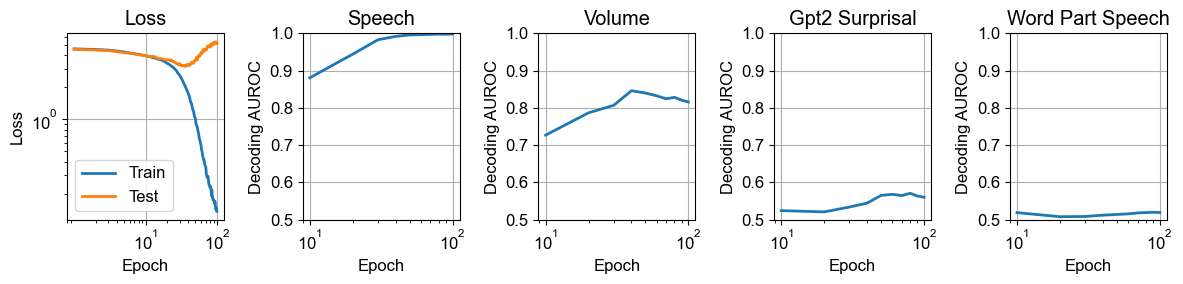

In [24]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Create figure with 5 subplots - one for loss, four for metrics
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 3))
fig.tight_layout(pad=3.0)

# Extract epochs and corresponding values
epochs = [stat['epoch'] for stat in training_statistics_store if 'train_loss' in stat]
train_loss = [stat['train_loss'] for stat in training_statistics_store if 'train_loss' in stat]
test_loss = [stat['test_loss'] for stat in training_statistics_store if 'test_loss' in stat]

# Plot losses
ax1.plot(epochs, train_loss, label='Train', linewidth=2)
ax1.plot(epochs, test_loss, label='Test', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks([10, 100])
ax1.legend()
ax1.grid(True)

# Plot metrics
metrics = ['speech', 'volume', 'gpt2_surprisal', 'word_part_speech']
axes = [ax2, ax3, ax4, ax5]

for ax, metric in zip(axes, metrics):
    auroc_values = [stat[f'eval_auroc/average_{metric}'] for stat in training_statistics_store 
                   if f'eval_auroc/average_{metric}' in stat]
    acc_values = [stat[f'eval_acc/average_{metric}'] for stat in training_statistics_store 
                 if f'eval_acc/average_{metric}' in stat]
    metric_epochs = [stat['epoch'] for stat in training_statistics_store 
                    if f'eval_auroc/average_{metric}' in stat]
    
    ax.plot(metric_epochs, auroc_values, label='AUROC', linewidth=2)
    #ax.plot(metric_epochs, acc_values, label='Accuracy')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Decoding AUROC')
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_xscale('log')
    ax.set_xticks([10, 100]) #[1, 10, 100]
    ax.set_ylim(0.5, 1.0)
    #ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.savefig(f'analyses/contra_training_exp_{dir_name}.png')
plt.show()